In [1]:
import numpy as np
import os
import pyloudnorm as pyln
from openai import OpenAI

import sys, random  
sys.path.insert(0, '../')
import utils
from utils.audio_generation import sample, get_model
from utils.audio_processing import compress_spectrogram_simple, compress_spectrogram_with_centroid


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
model_name = 'audioldm_16k_crossattn_t5' # Smaller model; Less GPU memory ~[6-9]GB; 
# model_name = 'audioldm2-full' # Larger model; More GPU memory ~[12-15] GB; 

#Audio params
loudness_dbfs = -14.0
sample_rate = 16000
stft_channels = 1024
hop_length = 128

# Diffusion params
guidance_scale = 3
n_candidates = 1
batch_size = 1
ddim_steps = 100

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'ti

# Foley Interpreter

In [7]:
with open('../config/.env', 'r') as fh:
    vars_dict = dict(
        tuple(line.replace('\n', '').split('='))
        for line in fh.readlines() if not line.startswith('#')
    )

os.environ.update(vars_dict)

In [8]:
client = OpenAI()
def foley_interpreter(txt):
    content = "Describe a language phrase consisting of a noun verb adjective adverb like "+\
            "'a brown cat running purposefully and quickly' that would be a sound which could be also perceivable "+\
            "as touch sensation and resembles "+txt+". Use simple words and long descriptions when generating the language phrase."
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
         {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": content}
      ]
    )

    foley_language_phrase = response.choices[0].message.content
    print(foley_language_phrase)
    print(foley_language_phrase.split('"')[1])
    return foley_language_phrase.split('"')[1]
    

# AI Audio Generator

In [9]:
def audio_generator(foley_language_phrase, latent_diffusion, random_seed):
    audio = sample(latent_diffusion, foley_language_phrase, batch_size=1, ddim_steps=100, guidance_scale=3.0, \
             random_seed=random_seed, disable_tqdmoutput=False)

    return audio

# Dynamic Audio Converter

In [10]:
def audio_post_processor(audio, freq_limit, hop_length, stft_channels, sample_rate, loudness):

    loudness_meter = pyln.Meter(sample_rate)
    wav_compressed_simple = compress_spectrogram_simple(audio, limit=freq_limit, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    wav_compressed_w_centroid = compress_spectrogram_with_centroid(audio, limit=freq_limit, hop_length=hop_length, stft_channels=stft_channels, \
                                                    sample_rate=sample_rate, loudness_meter=loudness_meter, loudness=loudness)

    _ = {\
         'simple compressed': wav_compressed_simple, \
         'compressed w/ centroid': wav_compressed_w_centroid\
        }
    return _

# Examples

How about: "A soft feather caressing gently and smoothly"? This phrase pairs a sensory experience of touch with the visual image of a feather moving gracefully and delicately, creating a feeling that could be likened to the sensation of a handshake.
A soft feather caressing gently and smoothly


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


Loudness before =  -19.559860103013722
Loudness after =  -29.999999999999996
Mean Spectral Centroid =  3205.722080114729 495.6159074682175
Loudness before =  -19.86351912446418
Loudness after =  -30.000000000000007
num rows= 1


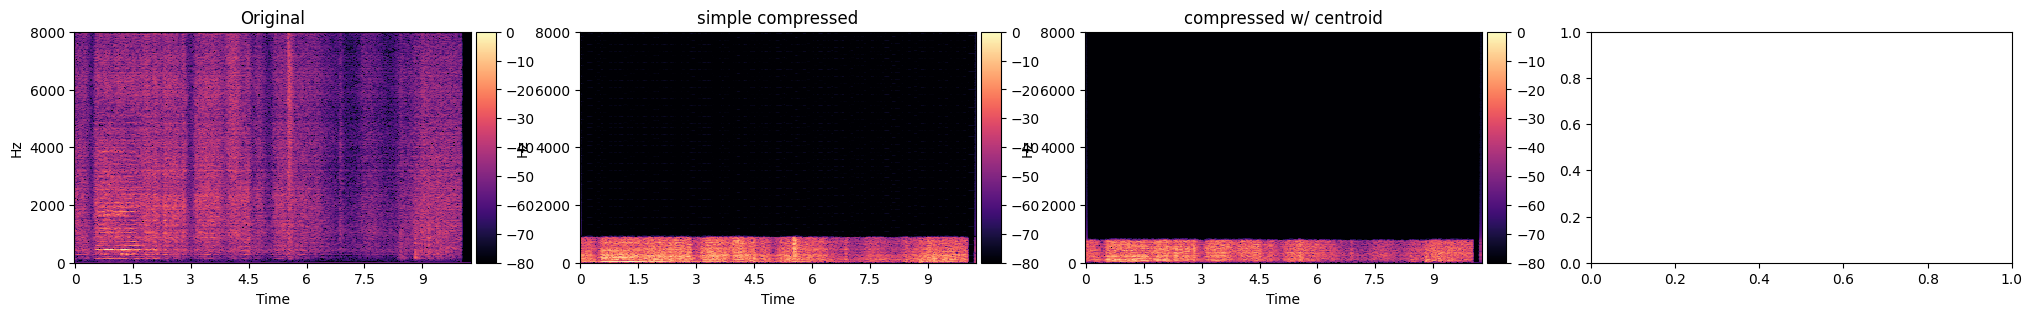

In [11]:
prompt = "a handshake"

foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(foley_language_phrase, latent_diffusion, np.random.randint(0,10000))
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)

all_wavs = [audio]
all_titles = ['Original']
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)

DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.87it/s]


Loudness before =  -19.77785794088808
Loudness after =  -29.999999999999996
Mean Spectral Centroid =  2403.2725736755933 427.8190899060034
Loudness before =  -14.382491424852665
Loudness after =  -29.99999999999999
num rows= 1


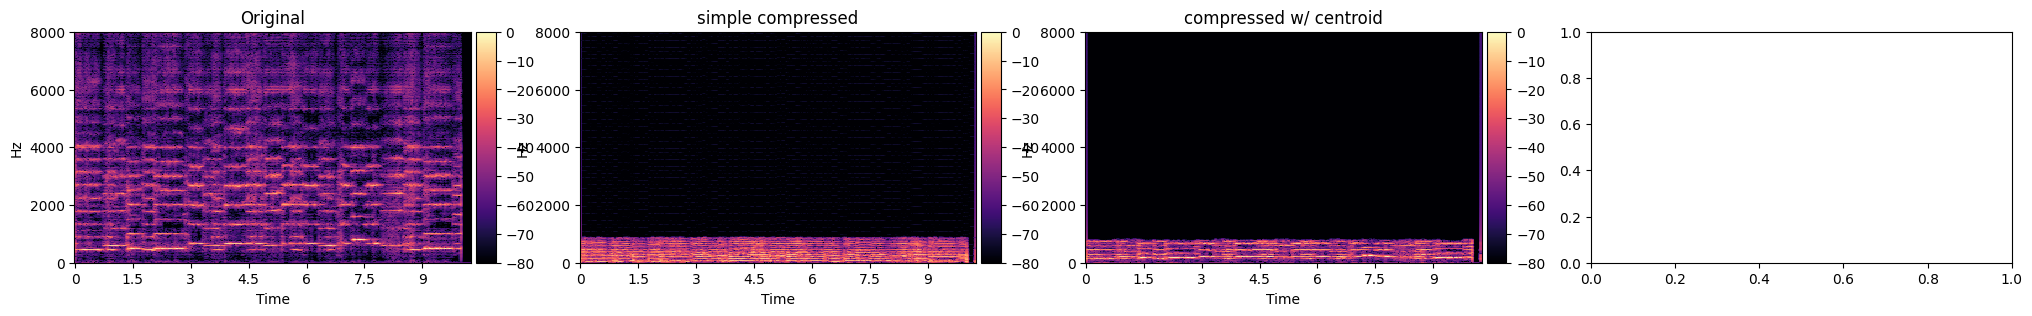

In [17]:
prompt = "A violin playing mournfully"

#foley_language_phrase = foley_interpreter(prompt)
audio = audio_generator(prompt, latent_diffusion, 1947)
audio_c = audio_post_processor(audio, freq_limit=1000, hop_length=hop_length, stft_channels=stft_channels, sample_rate=sample_rate, loudness=-30)

all_wavs = [audio]
all_titles = ['Original']
for key in audio_c:
    all_wavs.append(audio_c[key])
    all_titles.append(key)

utils.plot_all(all_wavs, all_titles)